In [1]:
!nvidia-smi

Mon Dec 25 15:44:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
#!python rapidsai-csp-utils/colab/pip-install.py

In [4]:
#pip install cudf-cu11==23.04 cuml-cu11==23.04 cugraph-cu11==23.04 cucim --extra-index-url=https://pypi.nvidia.com

In [5]:
pip install cudf-cu12==23.6.0 cuml-cu12==23.6.0 cugraph-cu12==23.6.0 cucim --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.3/493.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.1/959.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 702.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.4/582.4 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
#!nvcc --version

In [7]:
import cuml
import numpy as np
from cuml.svm import SVC
from cuml.svm import LinearSVC
from cuml.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification

In [8]:
import pandas as pd
import os
import cv2
import numpy as np

from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import make_scorer, f1_score

from datetime import datetime
import time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy,
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio),
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'

    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)

    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")

    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]

    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()

    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2)

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip "/content/drive/MyDrive/TFM/GLCM_CIR.zip" -d "/content"

Archive:  /content/drive/MyDrive/TFM/GLCM_CIR.zip
  inflating: /content/X_test_CIR.csv  
  inflating: /content/X_train_CIR.csv  
  inflating: /content/y_test_CIR.csv  
  inflating: /content/y_train_CIR.csv  


In [12]:
X_train = np.loadtxt("/content/X_train_CIR.csv", delimiter=",")
y_train = np.loadtxt('/content/y_train_CIR.csv', delimiter=",")
X_test = np.loadtxt('/content/X_test_CIR.csv', delimiter=",")
y_test = np.loadtxt('/content/y_test_CIR.csv', delimiter=",")

In [13]:
scorer = make_scorer(f1_score, pos_label=1)

In [14]:
import time
s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 0.5],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 1, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.0
79.8601484298706


In [15]:
best_params = grid_search.best_params_

In [16]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

[W] [15:51:03.462356] Random state is currently ignored by probabilistic SVC


In [17]:
best_svc_clf.fit(X_train, y_train)

SVC()

Max Sensitivity at Specificity >= 0.94: 0.10


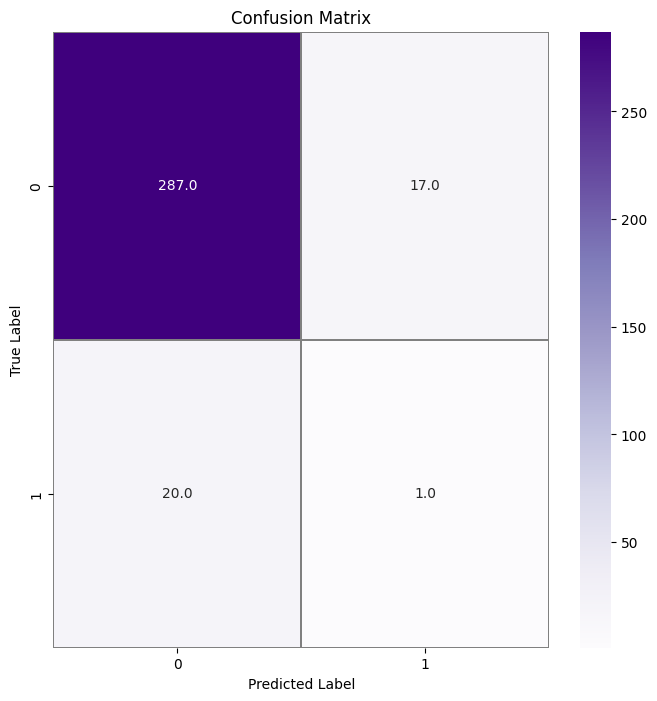

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       304
         1.0       0.06      0.05      0.05        21

    accuracy                           0.89       325
   macro avg       0.50      0.50      0.50       325
weighted avg       0.88      0.89      0.88       325

     Model Name  Max Sensitivity at Specificity 0.94   AUC  \
0  CIR-SVC-poly                                  0.1  0.63   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.05      0.89         0.05         0.94  0.06  0.93   

    PLR   NLR  
0  0.85  1.01  


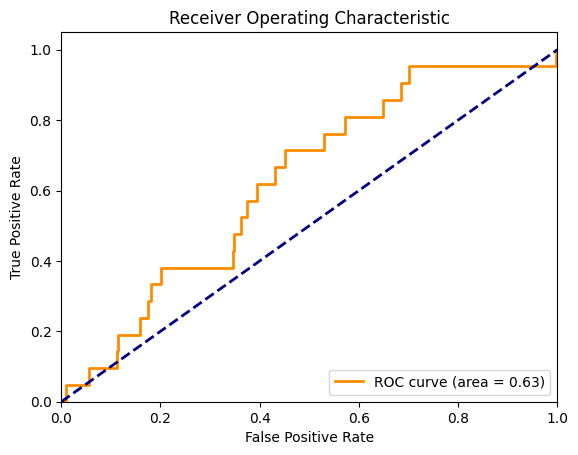

In [18]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-poly')

In [19]:
import time
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LinearSVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)


Best Parameters: {'C': 1000, 'class_weight': None}
Best Score: 0.012121212121212121
74.11042094230652


In [20]:
best_params = grid_search.best_params_

In [21]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

[W] [15:52:18.667700] Random state is currently ignored by probabilistic SVC


In [22]:
best_svc_clf.fit(X_train, y_train)

SVC()

Max Sensitivity at Specificity >= 0.94: 0.14


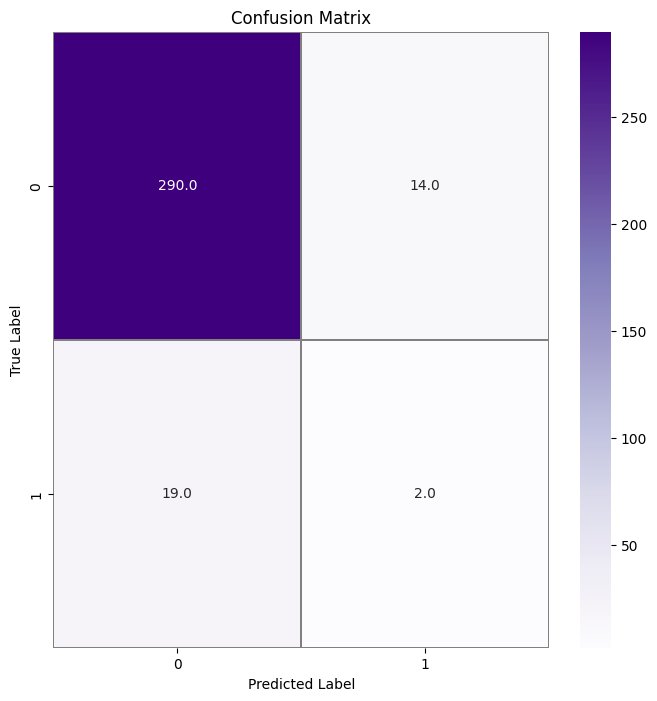

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       304
         1.0       0.12      0.10      0.11        21

    accuracy                           0.90       325
   macro avg       0.53      0.52      0.53       325
weighted avg       0.89      0.90      0.89       325

       Model Name  Max Sensitivity at Specificity 0.94   AUC  \
0  CIR-SVC-linear                                 0.14  0.56   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.11       0.9          0.1         0.95  0.12  0.94   

    PLR   NLR  
0  2.07  0.95  


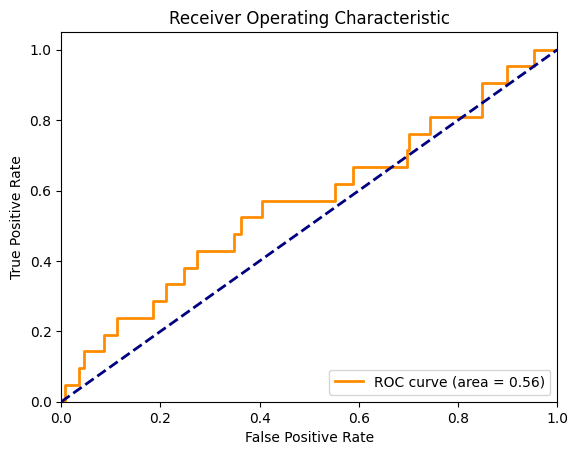

In [23]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-linear')